<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Model-Fitting" data-toc-modified-id="Model-Fitting-1">Model Fitting</a></span><ul class="toc-item"><li><span><a href="#Description-of-Model" data-toc-modified-id="Description-of-Model-1.1">Description of Model</a></span></li></ul></li><li><span><a href="#Description-of-Methodology" data-toc-modified-id="Description-of-Methodology-2">Description of Methodology</a></span></li><li><span><a href="#Reasonable-Assumptions" data-toc-modified-id="Reasonable-Assumptions-3">Reasonable Assumptions</a></span></li><li><span><a href="#Data-Preprocessing" data-toc-modified-id="Data-Preprocessing-4">Data Preprocessing</a></span><ul class="toc-item"><li><span><a href="#Feature-Generation" data-toc-modified-id="Feature-Generation-4.1">Feature Generation</a></span></li><li><span><a href="#Data-encoding" data-toc-modified-id="Data-encoding-4.2">Data encoding</a></span></li><li><span><a href="#Age" data-toc-modified-id="Age-4.3">Age</a></span></li><li><span><a href="#Gender" data-toc-modified-id="Gender-4.4">Gender</a></span></li><li><span><a href="#Race" data-toc-modified-id="Race-4.5">Race</a></span></li><li><span><a href="#Highest-Grade" data-toc-modified-id="Highest-Grade-4.6">Highest Grade</a></span></li><li><span><a href="#Tertiary-education" data-toc-modified-id="Tertiary-education-4.7">Tertiary education</a></span></li><li><span><a href="#Province" data-toc-modified-id="Province-4.8">Province</a></span></li><li><span><a href="#Moved-Province" data-toc-modified-id="Moved-Province-4.9">Moved Province</a></span></li><li><span><a href="#Labour-features" data-toc-modified-id="Labour-features-4.10">Labour features</a></span></li><li><span><a href="#Ensuring-data-is-balanced" data-toc-modified-id="Ensuring-data-is-balanced-4.11">Ensuring data is balanced</a></span></li><li><span><a href="#Model-construction" data-toc-modified-id="Model-construction-4.12">Model construction</a></span></li><li><span><a href="#Data-Splitting" data-toc-modified-id="Data-Splitting-4.13">Data Splitting</a></span></li><li><span><a href="#Model-Implementation" data-toc-modified-id="Model-Implementation-4.14">Model Implementation</a></span></li><li><span><a href="#Model-Selection-using-recursive-feature-elimination-with-cross-validation" data-toc-modified-id="Model-Selection-using-recursive-feature-elimination-with-cross-validation-4.15">Model Selection using recursive feature elimination with cross-validation</a></span></li></ul></li><li><span><a href="#Hypothesis-Testing" data-toc-modified-id="Hypothesis-Testing-5">Hypothesis Testing</a></span></li></ul></div>

# Brent Part 2 Rough Submission

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_selection import RFECV

In [2]:
lab = pd.read_csv("../Dino/Demographics.csv",)
dem = pd.read_csv("../Dino/Labour.csv")

In [3]:
df = pd.concat([dem,lab],axis=1)

## Model Fitting 

### Description of Model 

In order to further explore the effect of COVID-19 on the labour in South Africa, we propose a model that will attempt to predict whether or not someone would lose their job in the period of Feb 2020 - Apr 2020 due to COVID-19 and the resulting mandated lockdown. The model will be constructed using features from both the Demographics and the Labour section of the survey.

## Description of Methodology

Our model construction begins by first ensuring that the data is in the correct tiday format. Thereafter we do further data cleaning to deal with missing or erroneous values. Once the data is cleaned we encode the necessary varaibles using binary and one-hot encoding. 

The initial model is built using a selection of varaibles that we select using prior knowledge (outlined below). We then evaluate this models performance using various statistical measures. Once this evaluation is complete we  construct a different model using the feature selection technique of Recursive Feature Elimination and compare it's performance to our initial model.

## Reasonable Assumptions

* If a respondent has a missing value for tertairy education, we can assume that they do not have a tertiary education.
* If a respondent did not change provinces during the lockdown period then the province they are staying in at the time of the interveiw is the same as the one they were staying in before lockdown

## Data Preprocessing

It is important to note that this model will attempt to predict whether or not someone would lose their opportunity for work due to the COVID19 pandemic, therefore we will reduce our sample to a sample containing only those respondents who had work beforehand.

In [4]:
df = df[df.labour_in_feb==1]

### Feature Generation

In [5]:
# Function to implement the assumption made about a respondents province as outlined above.
def check_province(moved,before,current):
    if moved=='Yes':
        return before 
    elif moved=='No':
        return current 

df['province'] = np.vectorize(check_province)(df['province_moved'], df['province_before'], df['province_current'])
df = df.drop(['province_current', 'province_before','province_during'], axis =1 )

col_order = ['age', 'gender', 'race', 'highest_grade', 'tertiary_edu','province',
       'province_moved', 'labour_in_feb', 'work_days_feb', 'work_hours_feb',
       'take_home_pay_feb', 'labour_in_apr', 'work_days_apr', 'work_hours_apr',
       'take_home_pay_apr', 'lost_labour', 'return_to_work', 'usual_work',
       ]

df = df.filter(col_order)

### Data encoding

### Age

In [6]:
# Age is already a continous numeric variable so we just need to remove the missing values 
df = df[df.age.notnull()]

### Gender  

In [7]:
df = df[df.gender.notnull()]
df['gender'] = df['gender'].map({'Man':1, 'Woman':0})
df['gender'] = df['gender'].astype(int)

### Race  

In [8]:
df = df[df.race.notnull()]
df = pd.get_dummies(df, columns=['race'], prefix='', prefix_sep = '')
col_order = ['age', 'gender','African/Black', 'Asian/Indian', 'Coloured', 'White',
             'highest_grade', 'tertiary_edu', 'province','province_moved', 
             'labour_in_feb', 'work_days_feb', 'work_hours_feb',
           'take_home_pay_feb', 'labour_in_apr', 'work_days_apr', 'work_hours_apr',
           'take_home_pay_apr', 'lost_labour', 'return_to_work', 'usual_work',
       ]

df = df.filter(col_order)

### Highest Grade  

Less than 5% of our sample has an education that is not one of the standard grades (Grade 1-Grade 12), we will remove these in order to encode the highest_grade feature accordingly

In [9]:
grade_map = {
    "Grade 12": 12,
    "Grade 11": 11, 
    "Grade 10": 10, 
    "Grade 9" : 9,
    "Grade 8" : 8, 
    "Grade 7" : 7,
    "Grade 6" : 6,
    "Grade 5" : 5, 
    "Grade 4" : 4,
    "Grade 3" : 3,
    "Grade 2" : 2, 
    "Grade 1" : 1,
    "Grade 0" : 0 
}
df.loc[:,'highest_grade'] = df.highest_grade.map(grade_map)
df = df[df.highest_grade.notnull()]
df.highest_grade = df.highest_grade.astype(int)

### Tertiary education 

In [10]:
def check_tert_edu(tert_edu):
    if tert_edu == "Yes":
        return 1
    else:
        return 0 
    
df.tertiary_edu = np.vectorize(check_tert_edu)(df['tertiary_edu'])

### Province

In [11]:
df = df[df.province.notnull()]
df = df[df.province!='nan']
df = pd.get_dummies(df, columns=['province'], prefix='', prefix_sep = '')

col_order = ['age', 'gender', 'African/Black', 'Asian/Indian', 'Coloured', 'White',
       'highest_grade', 'tertiary_edu', 'Eastern Cape', 'Free State', 'Gauteng',
       'KwaZulu-Natal', 'Limpopo', 'Mpumalanga', 'None', 'North West',
       'Northern Cape', 'Outside of South Africa', 'Western Cape','province_moved', 'labour_in_feb',
       'work_days_feb', 'work_hours_feb', 'take_home_pay_feb', 'labour_in_apr',
       'work_days_apr', 'work_hours_apr', 'take_home_pay_apr', 'lost_labour',
       'return_to_work', 'usual_work'
       ]

df = df.filter(col_order)

### Moved Province

In [12]:
df = df[df.province_moved.notnull()]
df['province_moved'] = df['province_moved'].map({'Yes':1, 'No':0})
df['province_moved'] = df['province_moved'].astype(int)

### Labour features

In [13]:
# All the labour features, other than "usual_work" are already in the corret numerical format, the missing values
# Just need to be removed 
df = df.dropna()

### Ensuring data is balanced

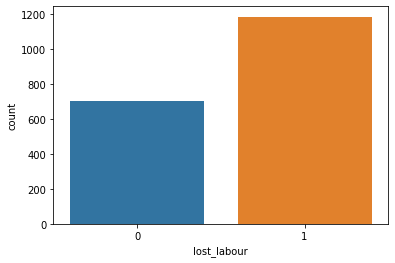

In [14]:
sns.countplot(data = df, x = 'lost_labour')
plt.show() 

### Model construction 

The first model we will construct will only use demographic features to try and make the prediction

In [15]:
model = df[['age', 'gender', 'African/Black', 'Asian/Indian', 'Coloured', 'White',
       'highest_grade', 'tertiary_edu', 'Eastern Cape', 'Free State',
       'Gauteng', 'KwaZulu-Natal', 'Limpopo', 'Mpumalanga', 'None',
       'North West', 'Northern Cape', 'Outside of South Africa',
       'Western Cape', 'province_moved', 'work_days_feb',
       'work_hours_feb', 'take_home_pay_feb', 'lost_labour']]

### Data Splitting

In [16]:
X = model.drop('lost_labour',axis=1)
y = model['lost_labour']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

### Model Implementation

In [17]:
log_model = LogisticRegression(max_iter=10000)
log_model.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [18]:
y_pred = log_model.predict(X_test)
accuracy_score(y_test, y_pred)  

0.7160493827160493

### Model Selection using recursive feature elimination with cross-validation

In [19]:
rfecv = RFECV(estimator=log_model, step=1, cv=5, scoring='accuracy')
rfecv = rfecv.fit(X_train, y_train)

print('Optimal number of features:', rfecv.n_features_)
print('Best featurues :', X_train.columns[rfecv.support_])

Optimal number of features: 21
Best featurues : Index(['age', 'gender', 'African/Black', 'Asian/Indian', 'Coloured', 'White',
       'highest_grade', 'tertiary_edu', 'Eastern Cape', 'Free State',
       'Gauteng', 'KwaZulu-Natal', 'Limpopo', 'Mpumalanga', 'North West',
       'Northern Cape', 'Western Cape', 'province_moved', 'work_days_feb',
       'work_hours_feb', 'take_home_pay_feb'],
      dtype='object')


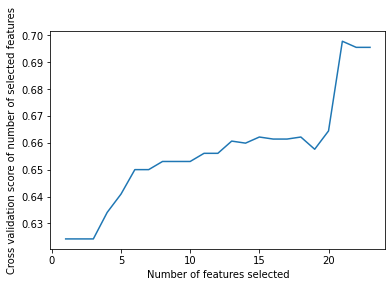

In [20]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1,len(rfecv.grid_scores_)+1), rfecv.grid_scores_)
plt.show()

In [21]:
X_train_rfecv = rfecv.transform(X_train)
X_test_rfecv = rfecv.transform(X_test)
log_model_rfecv = log_model.fit(X_train_rfecv,y_train)
y_pred = log_model_rfecv.predict(X_test_rfecv)
accuracy_score(y_test, y_pred)  

0.7178130511463845

## Hypothesis Testing

I am not entirely sure what to do for the hypthesis testing in this case, please could you elaborate on possible hypothesis tests I could conduct for the Logistic Regression. 